# Exploring Dandiset 000690: Allen Institute Openscope - Vision2Hippocampus project

*Note: This notebook was AI-generated and has not been fully verified. Please be cautious when interpreting the code or results.*

## Overview

This notebook explores Dandiset 000690 (version 0.250326.0015), which contains neural recording data from the Allen Institute's Openscope Vision2Hippocampus project. The project investigates how visual stimuli representations evolve from thalamus through visual cortex and hippocampus in the mouse brain.

You can access the original Dandiset at: [https://dandiarchive.org/dandiset/000690/0.250326.0015](https://dandiarchive.org/dandiset/000690/0.250326.0015)

In this notebook, we will:
- Load and explore the Dandiset metadata
- Examine the types of stimuli presented to the animals
- Investigate the extracellular electrophysiology data structure
- Analyze LFP (Local Field Potential) signals
- Explore unit spiking activity
- Examine neural responses to different visual stimuli

Let's start exploring!

## Required Packages

The following packages are required to run this notebook:

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import islice
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Set the plotting style
sns.set_theme()

## Loading the Dandiset

Let's connect to the DANDI archive and load the Dandiset:

In [2]:
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("000690", "0.250326.0015")

# Print basic information about the Dandiset
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")
print(f"Dandiset description: {metadata['description'][:500]}...")  # Truncate for readability

Dandiset name: Allen Institute Openscope - Vision2Hippocampus project
Dandiset URL: https://dandiarchive.org/dandiset/000690/0.250326.0015
Dandiset description: Extensive research shows that visual cortical neurons respond to specific stimuli, e.g. the primary visual cortical neurons respond to bars of light with specific orientation. In contrast, the hippocampal neurons are thought to encode not specific stimuli but instead represent abstract concepts such as space, time and events. How is this abstraction computed in the mouse brain? Specifically, how does the representation of simple visual stimuli evolve from the thalamus, which is a synapse away fr...


### Examining the Dandiset Assets

Let's list some assets in the Dandiset to understand its structure:

In [3]:
# List the first few assets
assets = dandiset.get_assets()
print("\nFirst 10 assets:")
for asset in islice(assets, 10):
    print(f"- {asset.path} (ID: {asset.identifier})")


First 10 assets:
- sub-692077/sub-692077_ses-1300222049_probe-4_ecephys.nwb (ID: b0ea16d5-42eb-4b56-87cc-7d7b7efab4db)
- sub-692077/sub-692077_ses-1300222049_probe-3_ecephys.nwb (ID: e0ad1921-75f1-43ed-aa86-8e1a45a9f49d)
- sub-692077/sub-692077_ses-1300222049_probe-2_ecephys.nwb (ID: 97712120-158d-492a-ae21-61515335bc18)
- sub-692077/sub-692077_ses-1300222049_probe-0_ecephys.nwb (ID: de12ccea-83a7-4d7f-937c-4c02e4d3bf44)
- sub-692077/sub-692077_ses-1300222049.nwb (ID: 8ae65111-a130-47fc-a108-55e695374739)
- sub-692077/sub-692077_ses-1300222049_probe-1_ecephys.nwb (ID: 9468bd20-0a79-46e4-9d88-cbdbe053398b)
- sub-695435/sub-695435_ses-1309235849_probe-3_ecephys.nwb (ID: 7d71b9d5-f5c2-4a52-9538-16d86cf02602)
- sub-695435/sub-695435_ses-1309235849_probe-1_ecephys.nwb (ID: 845c2c40-0774-4b5d-aa75-9aa109ea9c85)
- sub-695435/sub-695435_ses-1309235849_probe-0_ecephys.nwb (ID: ecaed1ec-a8b5-4fe7-87c1-baf68cfa900f)
- sub-695435/sub-695435_ses-1309235849_probe-2_ecephys.nwb (ID: 2ab49756-502a-49

The Dandiset contains data from multiple subjects, with each subject having multiple NWB files:

- A main session file (.nwb)
- An image file containing visual stimuli (\_image.nwb)
- Multiple probe-specific electrophysiology files (\_probe-N\_ecephys.nwb)

This organization allows for efficient data storage and access, separating the large electrophysiology recordings into manageable files.

## Exploring Visual Stimuli

The Vision2Hippocampus project presented various visual stimuli to mice while recording neural activity. Let's explore the types of stimuli used in the experiments.

The main stimulus categories were:

1. **Simple visual motion** stimuli like bars of light with different properties
2. **Complex natural visual stimuli** including movies of eagles and other natural scenes

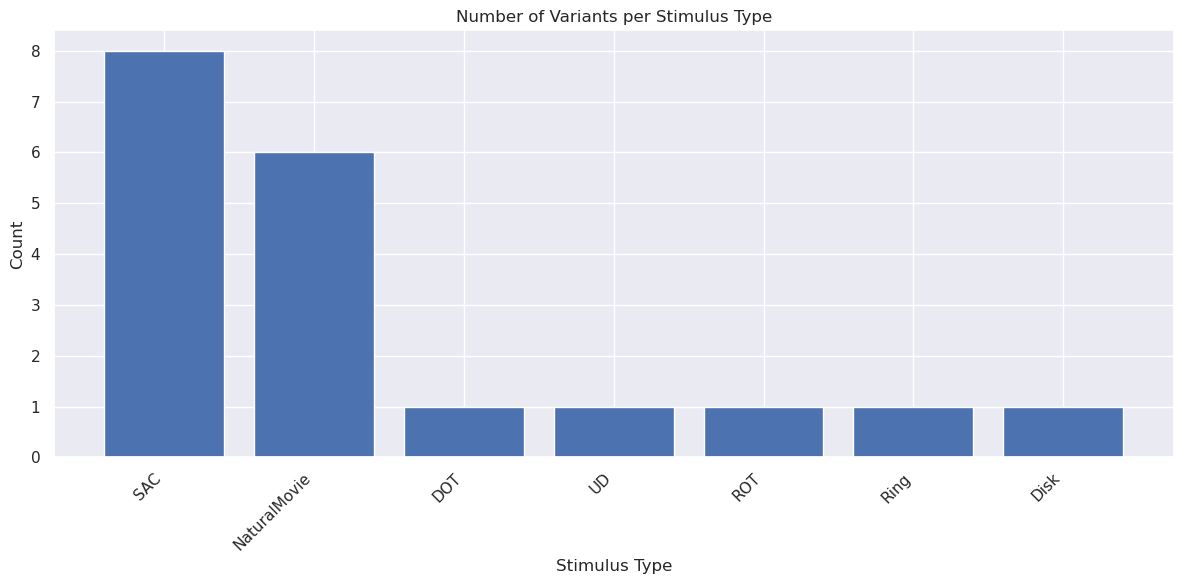

In [4]:
# We'll define stimulus information based on their naming patterns
stimulus_info = [
    {"name": "Stim01_SAC_Wd15_Vel2_White_loop", "type": "SAC", "width": "15°", "velocity": "2", "color": "White", "pattern": "loop"},
    {"name": "Stim02_SAC_Wd45_Vel2_White_loop", "type": "SAC", "width": "45°", "velocity": "2", "color": "White", "pattern": "loop"},
    {"name": "Stim03_SAC_Wd15_Vel2_White_oneway_1", "type": "SAC", "width": "15°", "velocity": "2", "color": "White", "pattern": "one-way"},
    {"name": "Stim04_SAC_Wd15_Vel2_Black_loop", "type": "SAC", "width": "15°", "velocity": "2", "color": "Black", "pattern": "loop"},
    {"name": "Stim05_SAC_Wd15_Vel2_White_oneway_2", "type": "SAC", "width": "15°", "velocity": "2", "color": "White", "pattern": "one-way"},
    {"name": "Stim06_SAC_Wd15_Vel2_White_scramble", "type": "SAC", "width": "15°", "velocity": "2", "color": "White", "pattern": "scrambled"},
    {"name": "Stim07_DOT_Wd15_Vel2_White_loop", "type": "DOT", "width": "15°", "velocity": "2", "color": "White", "pattern": "loop"},
    {"name": "Stim08_SAC_Wd15_Vel6_White_loop", "type": "SAC", "width": "15°", "velocity": "6", "color": "White", "pattern": "loop"},
    {"name": "Stim09_UD_Wd15_Vel2_White_loop", "type": "UD", "width": "15°", "velocity": "2", "color": "White", "pattern": "loop"},
    {"name": "Stim10_ROT_Wd15_Vel2_White_loop", "type": "ROT", "width": "15°", "velocity": "2", "color": "White", "pattern": "loop"},
    {"name": "Stim11_Ring_Wd15_Vel2_White_loop", "type": "Ring", "width": "15°", "velocity": "2", "color": "White", "pattern": "loop"},
    {"name": "Stim12_Disk_Wd15_Vel2_White_loop", "type": "Disk", "width": "15°", "velocity": "2", "color": "White", "pattern": "loop"},
    {"name": "Stim13_SAC_Wd15_Vel2_Disco_loop", "type": "SAC", "width": "15°", "velocity": "2", "color": "Disco", "pattern": "loop"},
    {"name": "Stim14_natmovie_10secFast_EagleSwoop", "type": "NaturalMovie", "description": "10 sec Fast Eagle Swoop"},
    {"name": "Stim15_natmovie_20sec_EagleSwoop", "type": "NaturalMovie", "description": "20 sec Eagle Swoop"},
    {"name": "Stim16A_natmovie_20sec_Flipped_A_EagleSwoop", "type": "NaturalMovie", "pattern": "flipped", "description": "20 sec Flipped A Eagle Swoop"},
    {"name": "Stim16B_natmovie_20sec_Flipped_B_EagleSwoop", "type": "NaturalMovie", "pattern": "flipped", "description": "20 sec Flipped B Eagle Swoop"},
    {"name": "Stim17A_natmovie_20sec_Occluded1to1_A_EagleSwoop", "type": "NaturalMovie", "pattern": "occluded", "description": "20 sec Occluded A Eagle Swoop"},
    {"name": "Stim17B_natmovie_20sec_Occluded1to1_B_EagleSwoop", "type": "NaturalMovie", "pattern": "occluded", "description": "20 sec Occluded B Eagle Swoop"}
]

# Create DataFrame for visualization
stimulus_df = pd.DataFrame(stimulus_info)

# Group by stimulus type to see the distribution
stim_counts = stimulus_df['type'].value_counts().reset_index()
stim_counts.columns = ['Stimulus Type', 'Count']

# Plot the distribution of stimulus types
plt.figure(figsize=(12, 6))
plt.bar(stim_counts['Stimulus Type'], stim_counts['Count'])
plt.xlabel('Stimulus Type')
plt.ylabel('Count')
plt.title('Number of Variants per Stimulus Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

As we can see from the plot, the dataset includes several types of visual stimuli:

- **SAC** (Static/Saccade): This is the most common stimulus type, with 8 different variants exploring different widths, velocities, colors, and patterns.
- **NaturalMovie**: 6 variants of natural movies showing eagles, including different speeds, flipped, and occluded versions.
- Several other stimulus types (DOT, DISK, ROT, Ring, UD) with 1 variant each.

Let's create a table to see more details about the SAC stimulus variants:

In [5]:
# Create a table with SAC stimulus details
sac_stims = stimulus_df[stimulus_df['type'] == 'SAC']
sac_stims[['name', 'width', 'velocity', 'color', 'pattern']].sort_values('name')

,name,width,velocity,color,pattern
0,Stim01_SAC_Wd15_Vel2_White_loop,15°,2,White,loop
1,Stim02_SAC_Wd45_Vel2_White_loop,45°,2,White,loop
2,Stim03_SAC_Wd15_Vel2_White_oneway_1,15°,2,White,one-way
3,Stim04_SAC_Wd15_Vel2_Black_loop,15°,2,Black,loop
4,Stim05_SAC_Wd15_Vel2_White_oneway_2,15°,2,White,one-way
5,Stim06_SAC_Wd15_Vel2_White_scramble,15°,2,White,scrambled
7,Stim08_SAC_Wd15_Vel6_White_loop,15°,6,White,loop
12,Stim13_SAC_Wd15_Vel2_Disco_loop,15°,2,Disco,loop


This table shows how the experiments systematically varied different parameters of the SAC stimulus:

- Width: 15° or 45°
- Velocity: 2 or 6
- Color: White, Black, or Disco (colored stripes)
- Pattern: loop, one-way, or scrambled

Now, let's also look at the natural movie stimuli:

In [6]:
# Create a table with natural movie stimulus details
nat_stims = stimulus_df[stimulus_df['type'] == 'NaturalMovie']
nat_stims[['name', 'description', 'pattern']]

,name,description,pattern
13,Stim14_natmovie_10secFast_EagleSwoop,10 sec Fast Eagle Swoop,NaN
14,Stim15_natmovie_20sec_EagleSwoop,20 sec Eagle Swoop,NaN
15,Stim16A_natmovie_20sec_Flipped_A_EagleSwoop,20 sec Flipped A Eagle Swoop,flipped
16,Stim16B_natmovie_20sec_Flipped_B_EagleSwoop,20 sec Flipped B Eagle Swoop,flipped
17,Stim17A_natmovie_20sec_Occluded1to1_A_EagleSwoop,20 sec Occluded A Eagle Swoop,occluded
18,Stim17B_natmovie_20sec_Occluded1to1_B_EagleSwoop,20 sec Occluded B Eagle Swoop,occluded


These natural movie stimuli include different variants of eagle videos, with modifications like:
- Different durations (10s vs 20s)
- Flipped versions (to test mirror image processing)
- Occluded versions (to test partial visual information processing)

These systematic variations allow researchers to examine how different visual features are processed throughout the visual pathway to the hippocampus.

## Examining Electrophysiology Data

Now let's look at the neural recording data. We'll load a probe-specific NWB file to explore the electrophysiology data structure.

In [7]:
# Load a probe NWB file (we'll use probe 0 for the first subject)
url = "https://api.dandiarchive.org/api/assets/59aa163a-187a-414e-ba78-01163c2a789b/download/"
print(f"Loading NWB file from {url}")
print("This might take a moment as we're accessing a remote file...")

remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

print(f"\nProbe LFP file loaded.")
print(f"Session ID: {nwb.session_id}")
print(f"Session description: {nwb.session_description}")

Loading NWB file from https://api.dandiarchive.org/api/assets/59aa163a-187a-414e-ba78-01163c2a789b/download/
This might take a moment as we're accessing a remote file...


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."



Probe LFP file loaded.
Session ID: 1324561527
Session description: LFP data and associated info for one probe


### Exploring LFP Data

Let's examine the LFP (Local Field Potential) data structure:

In [8]:
# Get LFP data
lfp = nwb.acquisition['probe_0_lfp']
lfp_data = lfp.electrical_series['probe_0_lfp_data']

# Get basic details about the LFP data
num_channels = lfp_data.data.shape[1]
num_timepoints = lfp_data.data.shape[0]
sampling_rate = 1000.0 / np.median(np.diff(lfp_data.timestamps[:1000])) # estimate from first 1000 samples

print(f"Number of channels: {num_channels}")
print(f"Number of timepoints: {num_timepoints}")
print(f"Sampling rate (estimated): {sampling_rate:.2f} Hz")

# Get locations of electrodes
electrodes_table = lfp_data.electrodes.table
electrodes_info = electrodes_table.to_dataframe()
print(f"\nElectrode locations: {electrodes_info['location'].unique()}")

Number of channels: 96
Number of timepoints: 10295112
Sampling rate (estimated): 41.67 Hz

Electrode locations: ['MRN' 'MB' 'PF' 'TH' 'DG-mo' 'DG-sg' 'CA1' 'RSPd6b' 'RSPd6a' 'RSPd5'
 'RSPagl2/3' 'RSPagl1' 'root']


The electrodes are located in various brain regions, including:

- MRN (Midbrain Reticular Nucleus)  
- MB (Mammillary Body)
- PF (Parafascicular Nucleus)
- TH (Thalamus)
- DG-mo and DG-sg (Dentate Gyrus, molecular and granular layers)
- CA1 (Hippocampus CA1 region)
- RSPd6b, RSPd6a, RSPd5, RSPagl2/3, RSPagl1 (Retrosplenial Cortex layers)

This demonstrates how the recordings span from thalamic regions through visual cortex and into hippocampus, allowing the researchers to track visual information processing along this pathway.

### Visualizing LFP Data

Let's visualize a small segment of LFP data from a subset of channels to see what the signals look like:

Plotting 5 channels (every 20th channel)
Time segment: 60s to 65s


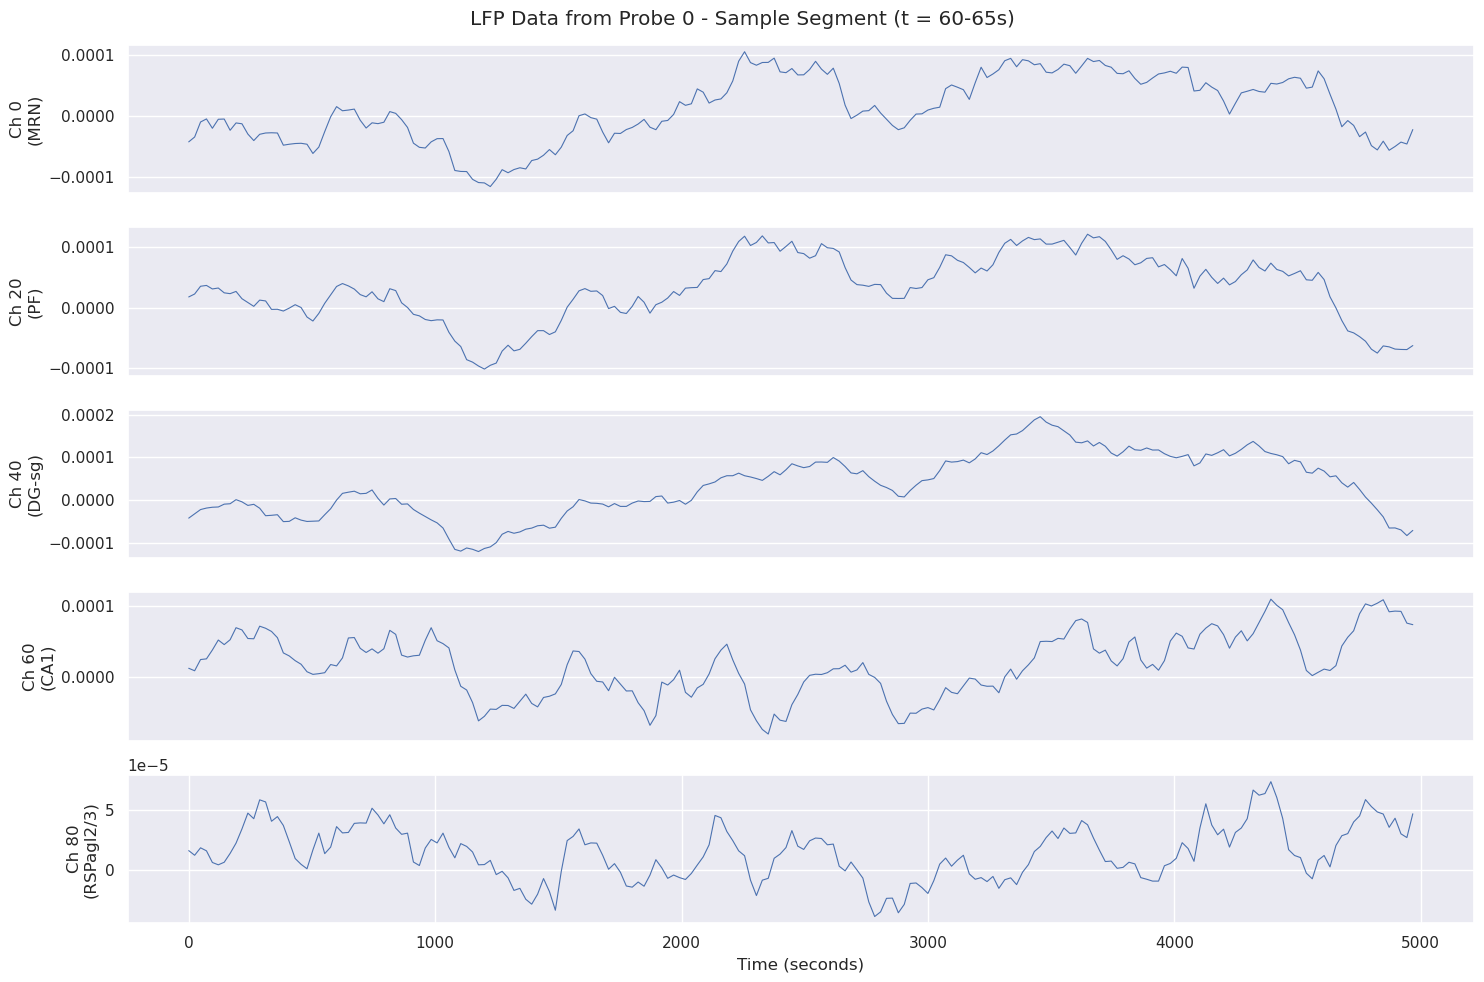

In [9]:
# Extract a short segment of data (5 seconds from 1 minute into recording)
start_time = 60  # seconds into recording
segment_duration = 5  # seconds
start_idx = int(start_time * sampling_rate)
end_idx = start_idx + int(segment_duration * sampling_rate)

# Make sure we don't exceed data bounds
if end_idx > num_timepoints:
    end_idx = num_timepoints

# Select a subset of channels to visualize (every 20th channel)
channel_step = 20
channels_to_plot = list(range(0, num_channels, channel_step))
num_plot_channels = len(channels_to_plot)

print(f"Plotting {num_plot_channels} channels (every {channel_step}th channel)")
print(f"Time segment: {start_time}s to {start_time + segment_duration}s")

# Extract the timestamps and data
timestamps = lfp_data.timestamps[start_idx:end_idx]
data_segment = lfp_data.data[start_idx:end_idx, channels_to_plot]

# Create plots
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(num_plot_channels, 1, figure=fig)

# Plot individual channels
for i, channel_idx in enumerate(channels_to_plot):
    ax = fig.add_subplot(gs[i, 0])
    ax.plot(timestamps - timestamps[0], data_segment[:, i], linewidth=0.8)
    
    # Get the location for this channel (if available)
    if 'location' in electrodes_info.columns:
        location = electrodes_info.iloc[channel_idx]['location']
        ax.set_ylabel(f"Ch {channel_idx}\n({location})")
    else:
        ax.set_ylabel(f"Ch {channel_idx}")
    
    # Remove x labels except for bottom subplot
    if i < num_plot_channels - 1:
        ax.set_xticks([])
    
# Add x-axis label to the bottom subplot
ax.set_xlabel("Time (seconds)")

plt.suptitle(f"LFP Data from Probe 0 - Sample Segment (t = {start_time}-{start_time + segment_duration}s)")
plt.tight_layout()
plt.show()

The LFP traces show coordinated rhythmic activity across multiple channels, with varying amplitudes depending on the brain region. Channels recording from the same or nearby regions tend to show similar patterns, while more distant regions may exhibit different rhythms.

We can observe that:

1. Channels show varying degrees of correlation in their activity patterns
2. There appear to be synchronized slow oscillations across many channels
3. The signal amplitude varies across channels, likely reflecting different local neural population activity levels

Next, let's look at the frequency content of the LFP signal using a spectrogram:

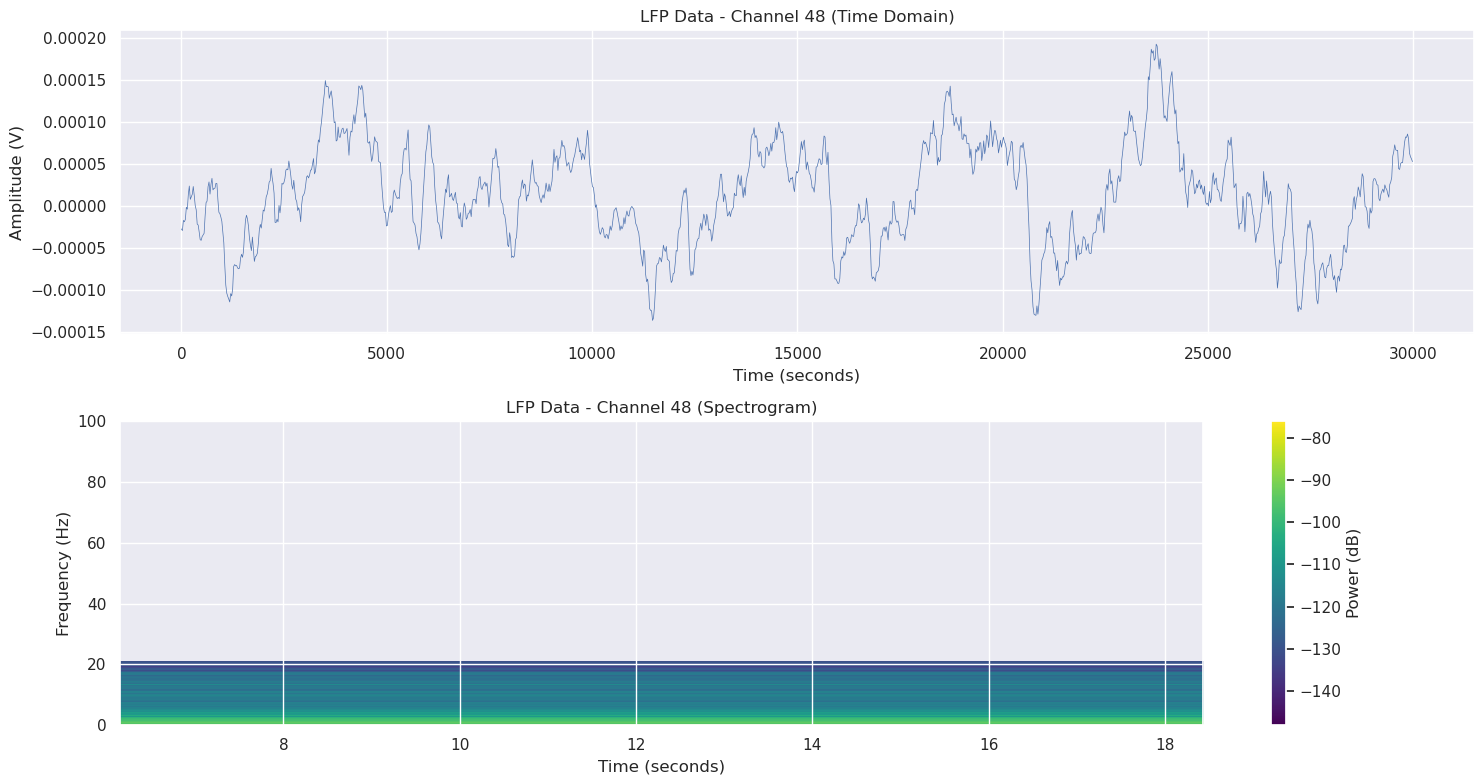

In [10]:
# Create a spectrogram for one channel
mid_channel = num_channels // 2

# Get a longer segment for better frequency resolution (30 seconds)
spec_duration = min(30, num_timepoints/sampling_rate-start_time)
spec_end_idx = start_idx + int(spec_duration * sampling_rate)

spec_timestamps = lfp_data.timestamps[start_idx:spec_end_idx]
spec_data = lfp_data.data[start_idx:spec_end_idx, mid_channel]

plt.figure(figsize=(15, 8))

# Plot the time series
plt.subplot(211)
plt.title(f"LFP Data - Channel {mid_channel} (Time Domain)")
plt.plot(spec_timestamps - spec_timestamps[0], spec_data, linewidth=0.5)
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (V)")

# Calculate and plot spectrogram
plt.subplot(212)
plt.title(f"LFP Data - Channel {mid_channel} (Spectrogram)")
# Use specgram for time-frequency analysis
Pxx, freqs, bins, im = plt.specgram(spec_data, NFFT=1024, Fs=sampling_rate, 
                                    noverlap=512, cmap='viridis')
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0, 100)  # Focus on frequencies up to 100 Hz which are most relevant for LFP
plt.colorbar(label="Power (dB)")

plt.tight_layout()
plt.show()

The spectrogram reveals the frequency content of the LFP signal over time. We can see that:

1. Most of the power is concentrated in the lower frequency bands (0-10 Hz), which is typical for LFP signals
2. There appears to be a prominent band in the theta range (4-8 Hz), which is commonly observed in hippocampal recordings
3. Higher frequencies (above 20 Hz) have much lower power
4. The frequency distribution remains relatively stable over time for this sample period

This frequency analysis helps us understand the oscillatory patterns in the neural activity, which are thought to be important for information processing and coordination across brain regions.

## Exploring Spiking Activity

Let's now examine the spiking activity recorded from individual neurons (units). For this, we'll need to load the main session NWB file which contains the units data:

In [11]:
# Load the main session NWB file 
main_url = "https://api.dandiarchive.org/api/assets/9b14e3b4-5d3e-4121-ae5e-ced7bc92af4e/download/"
print(f"Loading main session NWB file from {main_url}")
print("This might take a moment as we're accessing a remote file...")

main_remote_file = remfile.File(main_url)
main_h5_file = h5py.File(main_remote_file)
main_io = pynwb.NWBHDF5IO(file=main_h5_file)
main_nwb = main_io.read()

print(f"\nMain session file loaded.")
print(f"Session ID: {main_nwb.session_id}")

# Access units data
units = main_nwb.units
units_df = units.to_dataframe()

# Basic statistics
print(f"Number of units (neurons): {len(units_df)}")

if 'firing_rate' in units_df.columns:
    firing_rates = units_df['firing_rate'].dropna()
    print(f"\nFiring rate statistics:")
    print(f"Mean firing rate: {firing_rates.mean():.2f} Hz")
    print(f"Median firing rate: {firing_rates.median():.2f} Hz")
    print(f"Min firing rate: {firing_rates.min():.2f} Hz")
    print(f"Max firing rate: {firing_rates.max():.2f} Hz")

if 'quality' in units_df.columns:
    quality_counts = units_df['quality'].value_counts()
    print("\nUnit quality distribution:")
    for quality, count in quality_counts.items():
        print(f"{quality}: {count} units ({100*count/len(units_df):.1f}%)")

Loading main session NWB file from https://api.dandiarchive.org/api/assets/9b14e3b4-5d3e-4121-ae5e-ced7bc92af4e/download/
This might take a moment as we're accessing a remote file...


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."



Main session file loaded.
Session ID: 1324561527


Number of units (neurons): 2960

Firing rate statistics:
Mean firing rate: 4.81 Hz
Median firing rate: 2.21 Hz
Min firing rate: 0.00 Hz
Max firing rate: 93.38 Hz

Unit quality distribution:
good: 2538 units (85.7%)
noise: 422 units (14.3%)


This dataset contains a large number of units (neurons), with varying firing rates and quality metrics. The good quality units represent the majority of the recorded neurons.

Let's visualize the distribution of firing rates:

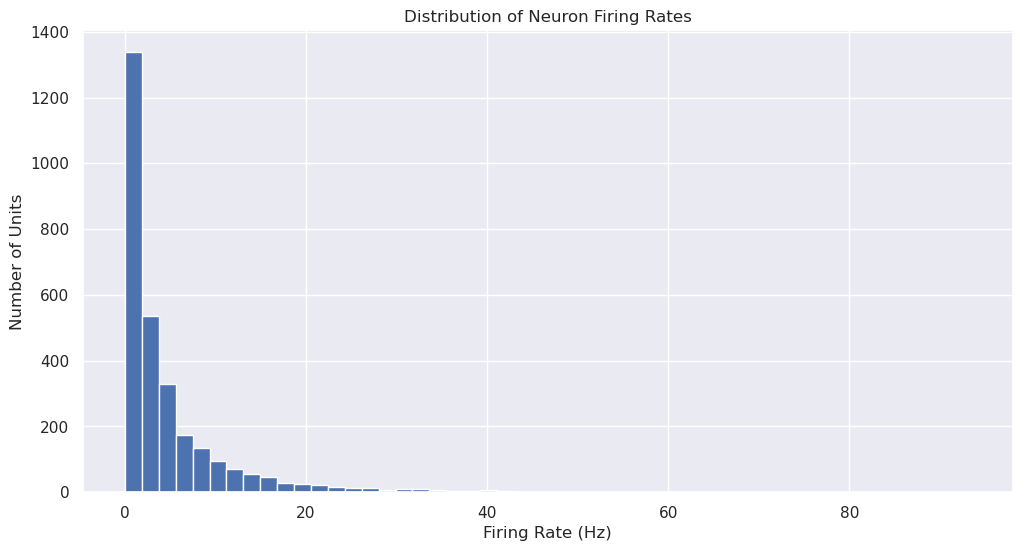

In [12]:
# Create a histogram of firing rates
plt.figure(figsize=(12, 6))
plt.hist(firing_rates, bins=50)
plt.xlabel('Firing Rate (Hz)')
plt.ylabel('Number of Units')
plt.title('Distribution of Neuron Firing Rates')
plt.show()

The firing rate distribution is heavily skewed towards low values, which is typical for cortical and hippocampal neurons. Most neurons fire at rates below 10 Hz, while a small number of neurons exhibit much higher firing rates (up to 90+ Hz). These high-firing neurons might be inhibitory interneurons, which often have higher baseline firing rates than excitatory neurons.

Next, let's examine the waveform properties to see if we can identify different cell types:

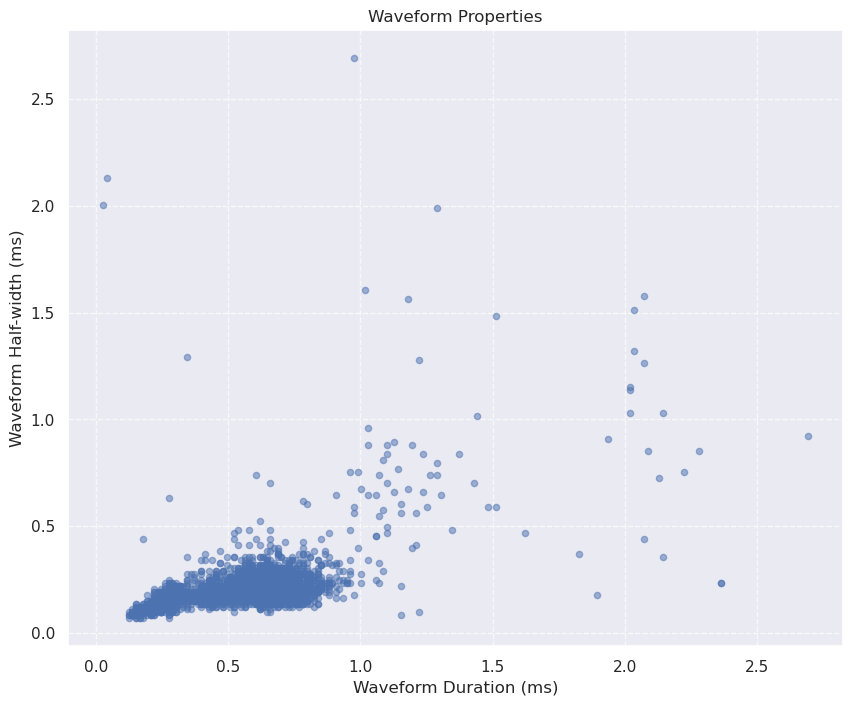

In [13]:
# Create a scatter plot of waveform properties if available
if 'waveform_duration' in units_df.columns and 'waveform_halfwidth' in units_df.columns:
    plt.figure(figsize=(10, 8))
    plt.scatter(units_df['waveform_duration'], units_df['waveform_halfwidth'], 
               alpha=0.5, s=20)
    plt.xlabel('Waveform Duration (ms)')
    plt.ylabel('Waveform Half-width (ms)')
    plt.title('Waveform Properties')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

The scatter plot of waveform properties reveals clusters that likely correspond to different cell types:

1. A main cluster with short duration and narrow half-width spikes, typically associated with fast-spiking inhibitory interneurons
2. A more dispersed set of units with longer duration and wider half-width spikes, characteristic of regular-spiking excitatory pyramidal neurons

This clustering based on spike waveform properties is a common approach to distinguishing between different neuronal cell types in extracellular recordings.

## Stimulus-Response Analysis

A key aspect of this dataset is the investigation of how visual stimuli are represented and transformed across brain regions. Let's examine how neurons respond to different types of visual stimuli.

First, let's identify the stimulus presentations in the dataset:

In [14]:
# Get all the stimulus intervals
stimuli_intervals = [name for name in main_nwb.intervals.keys() if "presentations" in name]
print(f"Number of stimulus types: {len(stimuli_intervals)}")
print("First 5 stimulus types:")
for stim in stimuli_intervals[:5]:
    print(f"- {stim}")

Number of stimulus types: 20
First 5 stimulus types:
- Stim01_SAC_Wd15_Vel2_White_loop_presentations
- Stim02_SAC_Wd45_Vel2_White_loop_presentations
- Stim03_SAC_Wd15_Vel2_White_oneway_1_presentations
- Stim04_SAC_Wd15_Vel2_Black_loop_presentations
- Stim05_SAC_Wd15_Vel2_White_oneway_2_presentations


To analyze neural responses to stimuli, we'd extract the spike times around stimulus presentations. However, this can be computationally intensive when loading data remotely. 

Below is an example of how you would analyze responses to specific stimuli. Note that running this code on the full dataset might require:
1. Downloading the NWB files locally
2. Limiting analysis to specific time windows, stimuli, or neurons
3. Using more sophisticated techniques like PSTH (Peri-Stimulus Time Histogram) analysis

### Response to Visual Stimuli (Conceptual Example)

The following code demonstrates the approach to analyzing stimulus responses, though it might not complete execution when accessing large files remotely:

```python
# Select a stimulus type to analyze
stim_type = "Stim01_SAC_Wd15_Vel2_White_loop_presentations"
stim_presentations = main_nwb.intervals[stim_type].to_dataframe()

# Select a few good quality units
good_units = units_df[units_df['quality'] == 'good'].index[:5]

# Analyze responses
for unit_id in good_units:
    spike_times = units.spike_times[unit_id]
    
    # For each stimulus presentation
    for _, stim in stim_presentations.head(10).iterrows():
        start_time = stim['start_time']
        stop_time = stim['stop_time']
        
        # Get spikes before and during stimulus
        pre_spikes = spike_times[(spike_times >= start_time-0.5) & (spike_times < start_time)]
        stim_spikes = spike_times[(spike_times >= start_time) & (spike_times < stop_time)]
        
        # Calculate firing rates
        pre_rate = len(pre_spikes) / 0.5 if len(pre_spikes) > 0 else 0
        stim_rate = len(stim_spikes) / (stop_time - start_time) if len(stim_spikes) > 0 else 0
        
        # Compare pre-stimulus and during-stimulus firing rates
        print(f"Unit {unit_id}: Pre-stim {pre_rate:.2f} Hz, During-stim {stim_rate:.2f} Hz")
```

This analysis would allow us to identify:
1. Neurons that increase their firing in response to stimuli (excitatory responses)
2. Neurons that decrease their firing (inhibitory responses) 
3. Neurons that show no significant change (non-responsive)

Further, by comparing responses to different stimulus types, we could characterize neurons based on their stimulus selectivity:
- Simple stimulus selective (e.g., responds to bars but not natural movies)
- Complex stimulus selective (e.g., responds to natural movies but not simple stimuli)
- Broadly responsive (responds to multiple stimulus types)

## Summary and Future Directions

In this notebook, we've explored Dandiset 000690, which contains neural recording data from the Allen Institute's Openscope Vision2Hippocampus project. We've examined:

1. The structure and organization of the Dandiset
2. The various visual stimuli used in the experiments, including both simple and complex stimuli
3. The LFP signals and their frequency content
4. The spiking activity of individual neurons and their properties
5. Approaches to analyzing stimulus-response relationships

This dataset offers rich opportunities for further analysis, including:

- **Stimulus representation across brain regions**: How do different regions encode simple vs. complex visual stimuli?
- **Temporal dynamics**: How do neural responses evolve over time during stimulus presentation?
- **Population coding**: How do large ensembles of neurons jointly encode stimulus features?
- **Region-specific processing**: Compare visual information processing in thalamus, visual cortex, and hippocampus
- **Neural correlates of behavior**: How do neural responses relate to the animal's running speed or eye movements?

The Dandiset contains a wealth of data from multiple animals, brain regions, and stimulus conditions, making it a valuable resource for investigating how visual information is processed and transformed throughout the brain.

## Conclusion

The Allen Institute Openscope Vision2Hippocampus project provides valuable insights into how visual stimuli are processed from early visual areas to hippocampus. This notebook demonstrates how to access and begin exploring this rich dataset, setting the foundation for more detailed analyses of neural coding and information processing in the visual system.

By examining both simple and complex stimuli, the dataset allows for a systematic investigation of how stimulus abstraction might occur as information progresses through the visual processing hierarchy, ultimately contributing to our understanding of how the brain creates internal representations of the external world.